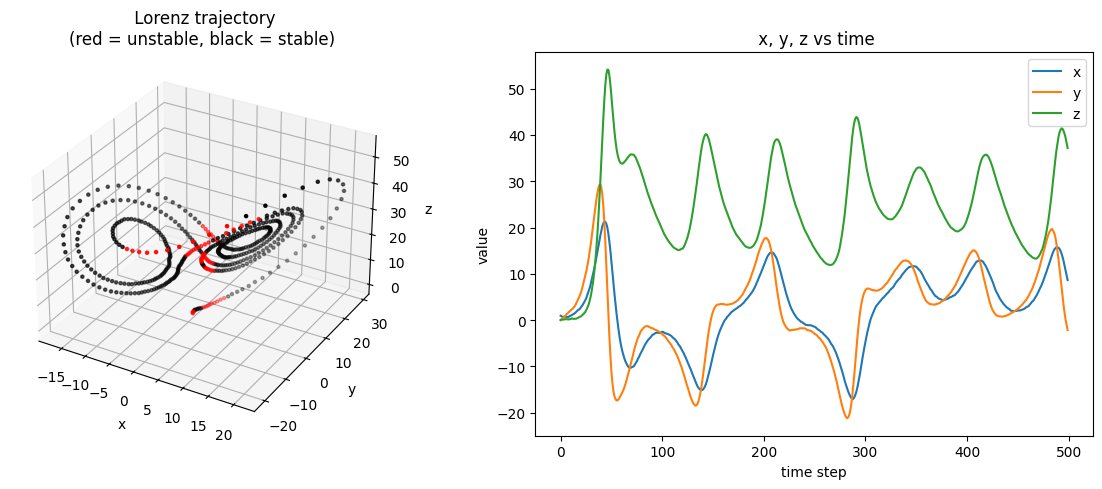

In [6]:
import argparse
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # needed for 3D


def load_sample(ds_name: str, split: str, idx: int):
    """
    Load one sample from data/<ds_name>/<split>.pkl

    Returns:
        X_sample: [T, 6]
        y_sample: [T]
    """
    data_path = Path("../data") / ds_name / f"{split}.pkl"
    with open(data_path, "rb") as f:
        data = pickle.load(f)

    X = np.asarray(data["X"])  # [N, T, 6]
    y = np.asarray(data["y"])  # [N, T]

    if idx < 0:
        idx = X.shape[0] + idx  # allow negative indexing

    X_sample = X[idx]          # [T, 6]
    y_sample = y[idx]          # [T]
    return X_sample, y_sample


def plot_lorenz_with_labels(X_sample: np.ndarray, y_sample: np.ndarray, title_prefix: str = ""):
    """
    X_sample: [T, 6]  (x, y, z, dx, dy, dz)
    y_sample: [T]     (0 = stable, 1 = unstable)
    """
    xyz = X_sample[:, :3]   # [T, 3]
    labels = y_sample       # [T]
    T = xyz.shape[0]
    t = np.arange(T)

    # colors: stable=black, unstable=red
    colors = np.where(labels == 1, "red", "black")

    fig = plt.figure(figsize=(12, 5))

    # --- 3D Lorenz trajectory ---
    ax3d = fig.add_subplot(1, 2, 1, projection="3d")
    ax3d.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors, s=5)
    ax3d.set_xlabel("x")
    ax3d.set_ylabel("y")
    ax3d.set_zlabel("z")
    ax3d.set_title(f"{title_prefix} Lorenz trajectory\n(red = unstable, black = stable)")

    # --- x, y, z vs time ---
    ax2d = fig.add_subplot(1, 2, 2)
    ax2d.plot(t, xyz[:, 0], label="x")
    ax2d.plot(t, xyz[:, 1], label="y")
    ax2d.plot(t, xyz[:, 2], label="z")
    ax2d.set_xlabel("time step")
    ax2d.set_ylabel("value")
    ax2d.set_title(f"{title_prefix} x, y, z vs time")
    ax2d.legend()

    fig.tight_layout()
    plt.show()




X_sample, y_sample = load_sample("lorenz_long", "train", 10)
plot_lorenz_with_labels(X_sample, y_sample, title_prefix="")



## Interaction curves

In [3]:
import pickle
from pathlib import Path
import numpy as np

# point this to the specific run you care about
run_dir = Path("../runs/lorenz/transformer_d_model16_layers2/ep100_bs32") / \
          "tau_max25_num_permutations20_interaction_methodih_noise0.1"

pkl_path = run_dir / "interaction_curves_ih.pkl"

with open(pkl_path, "rb") as f:
    interaction_curves = pickle.load(f)

print(type(interaction_curves))
print(getattr(interaction_curves, "shape", None))


<class 'numpy.ndarray'>
(32, 50, 26, 6, 6)


Loaded ../runs/lorenz/transformer_d_model16_layers2/ep100_bs32/tau_max25_num_permutations20_interaction_methodih_noise0.1/interaction_curves_ih.pkl
shape: (32, 50, 26, 6, 6)


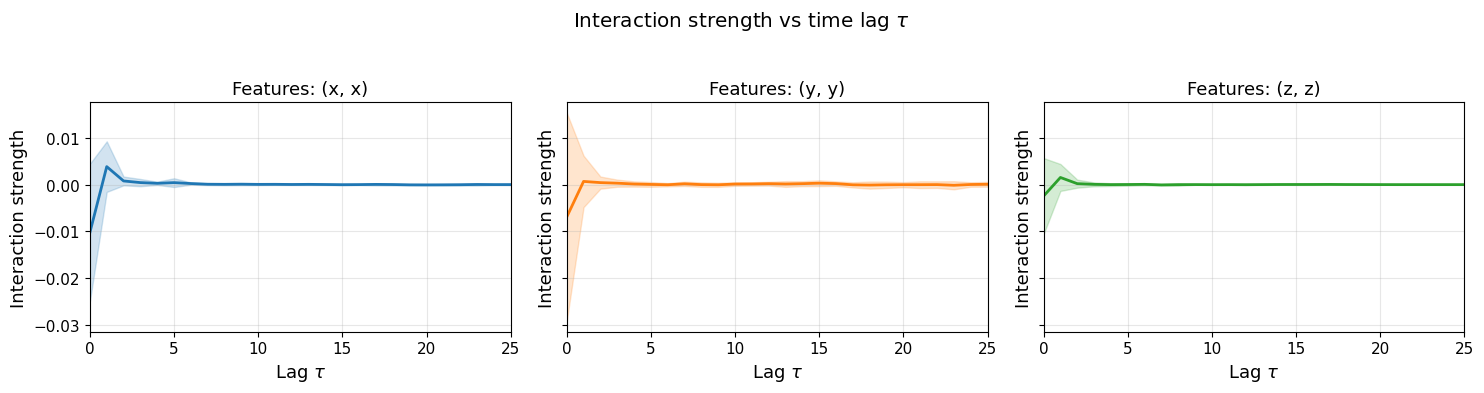

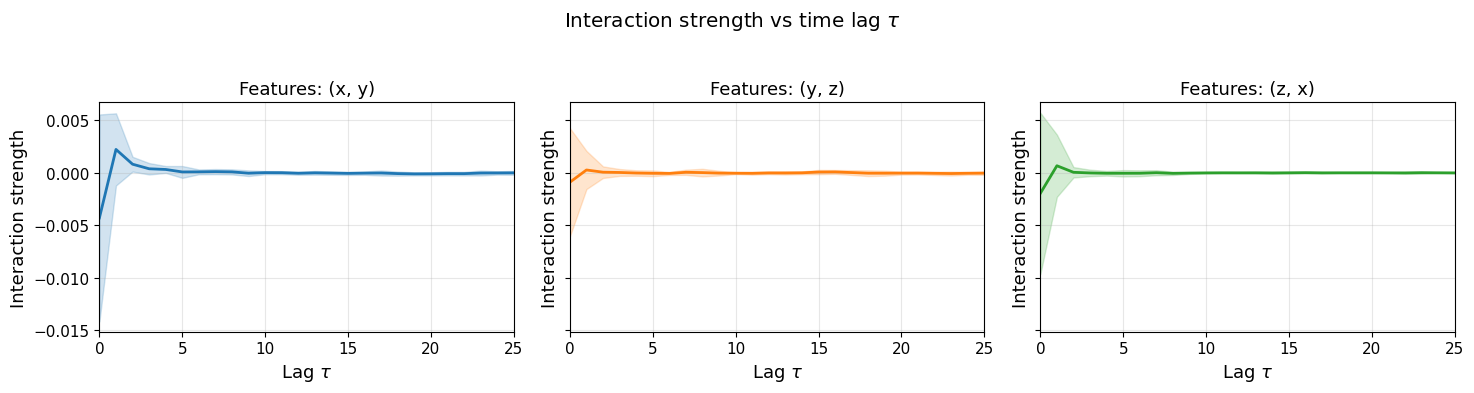

In [40]:
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


# --------- CONFIG ---------
# point this to the exact run folder
RUN_DIR = Path("../runs/lorenz/transformer_d_model16_layers2/ep100_bs32") / \
          "tau_max25_num_permutations20_interaction_methodih_noise0.1"

PKL_NAME = "interaction_curves_ih.pkl"
# --------------------------


def load_interaction_curves(path: Path) -> np.ndarray:
    with open(path, "rb") as f:
        arr = pickle.load(f)
    print("Loaded", path)
    print("shape:", arr.shape)
    return arr


def plot_diag_feature(ax, ih: np.ndarray, feat_idx1: int, feat_idx2: int, color=None):
    """
    ih: [B, T, tau, D, D]
    feat_idx: 0,1,2 for x,y,z (assuming first three features are positions)

    Plots mean ± std over B of |IH|, averaged over T.
    """
    B, T, tau_dim, D, _ = ih.shape
    taus = np.arange(tau_dim)

    # take diagonal for this feature: [B, T, tau]
    diag = ih[:, :, :, feat_idx1, feat_idx2]

    # interaction "strength" 
    strength = diag  # [B, T, tau]

    # average over T_init -> [B, tau]
    strength_T = strength.mean(axis=1)

    # mean/std over batch -> [tau]
    mean = strength_T.mean(axis=0)
    std = strength_T.std(axis=0)

    ax.plot(
        taus,
        mean,
        linewidth=2,
        label=f"d={feat_idx1},{feat_idx2}",
        color=color,
    )
    ax.fill_between(
        taus,
        mean - std,
        mean + std,
        alpha=0.2,
        color=color,
    )
    ax.set_xlabel(r"Lag $\tau$")
    ax.set_ylabel("Interaction strength")
    ax.grid(True, alpha=0.3)



ih_path = RUN_DIR / PKL_NAME
ih = load_interaction_curves(ih_path)  # [B, T, tau, D, D]
B, T, tau_dim, D, _ = ih.shape

# --- Matplotlib "ICML-ish" style tweaks ---
plt.style.use("default")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "lines.linewidth": 2.0,
})



feature_idx_to_name_map = {
    0: "x",
    1: "y",
    2: "z",
    3: "dx",
    4: "dy",
    5: "dz",
}


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

colors = ["tab:blue", "tab:orange", "tab:green"]
feature_indices = [[0,0], [1,1], [2,2]]

for ax, d_idx, c in zip(axes, feature_indices, colors):
    plot_diag_feature(ax, ih, feat_idx1=d_idx[0], feat_idx2=d_idx[1], color=c)
    ax.set_title(f"Features: ({feature_idx_to_name_map[d_idx[0]]}, {feature_idx_to_name_map[d_idx[1]]})")
    ax.set_xlim(0, tau_dim - 1)

fig.suptitle("Interaction strength vs time lag $\\tau$")
fig.tight_layout(rect=[0, 0.0, 1, 0.95])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

colors = ["tab:blue", "tab:orange", "tab:green"]
feature_indices = [[0, 1], [1, 2], [2, 0]]


for ax, d_idx, c in zip(axes, feature_indices, colors):
    plot_diag_feature(ax, ih, feat_idx1=d_idx[0], feat_idx2=d_idx[1], color=c)
    ax.set_title(f"Features: ({feature_idx_to_name_map[d_idx[0]]}, {feature_idx_to_name_map[d_idx[1]]})")
    ax.set_xlim(0, tau_dim - 1)

fig.suptitle("Interaction strength vs time lag $\\tau$")
fig.tight_layout(rect=[0, 0.0, 1, 0.95])

plt.show()

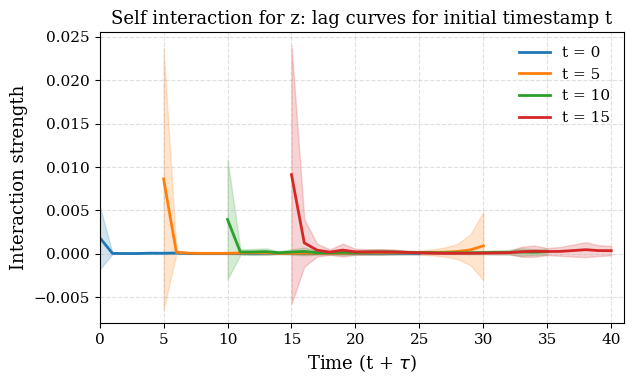

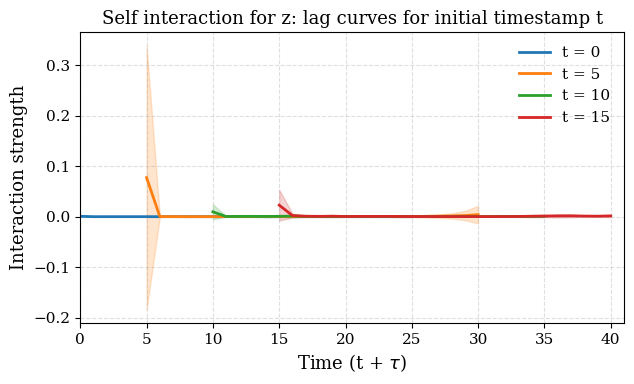

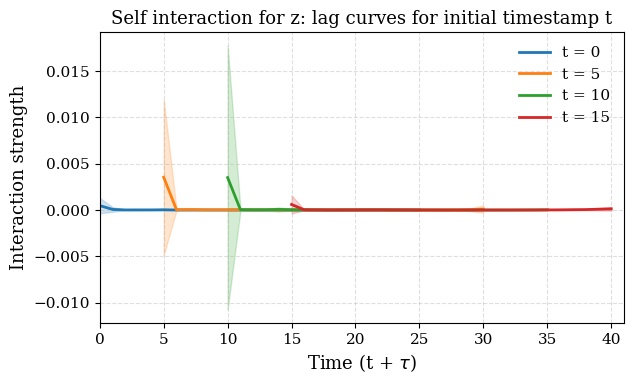

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ih is your interaction tensor: [B, T_init, tau, D, D]
ih = interaction_curves
B, T_init, tau_dim, D, _ = ih.shape

T_CHOICES = [0, 5, 10, 15]
FEATURES  = [[0, 0], [1, 1], [2, 2]]          # feature 1, 2, 3 (diagonal)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

taus = np.arange(tau_dim)

# ---- plotting style ----
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.4,
    "grid.linestyle": "--",
    "lines.linewidth": 2.0,
})

for d_idx1, d_idx2 in FEATURES:
    fig, ax = plt.subplots(figsize=(6.5, 4))

    for t0, c in zip(T_CHOICES, colors):
        if t0 >= T_init:
            continue

        # slice: [B, tau] for this feature at anchor time t0
        vals = ih[:, t0, :, d_idx1, d_idx2]      # [B, tau]
        strength = np.abs(vals)

        mean = strength.mean(axis=0)           # [tau]
        std  = strength.std(axis=0)            # [tau]

        # shift curve horizontally by t0
        x = taus + t0

        ax.plot(x, mean, color=c, label=f"t = {t0}")
        ax.fill_between(x, mean - std, mean + std, color=c, alpha=0.20)

    ax.set_xlabel(r"Time (t + $\tau$)")
    ax.set_ylabel("Interaction strength")
    ax.set_title(f"Self interaction for {feature_idx_to_name_map[d_idx[0]]}: lag curves for initial timestamp t")
    ax.legend(frameon=False)
    ax.set_xlim(0, max(T_CHOICES) + tau_dim)
    fig.tight_layout()

plt.show()


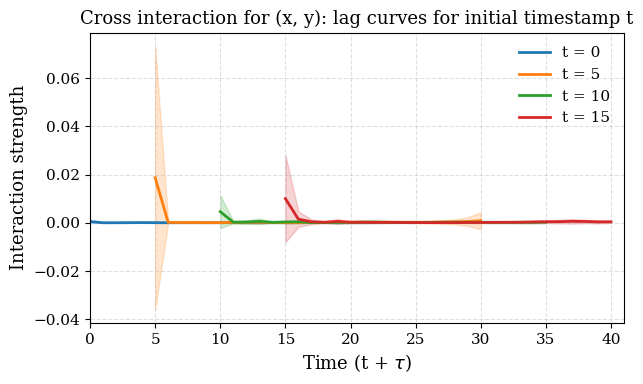

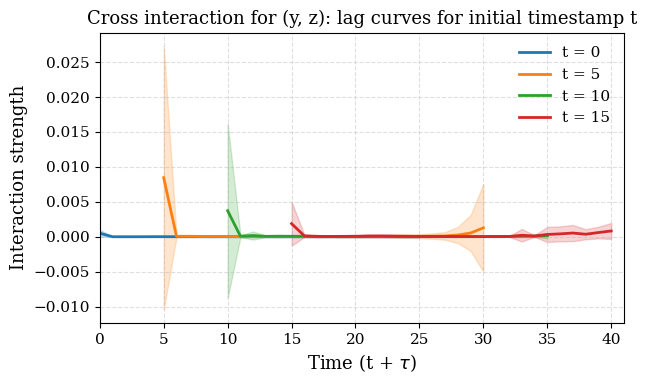

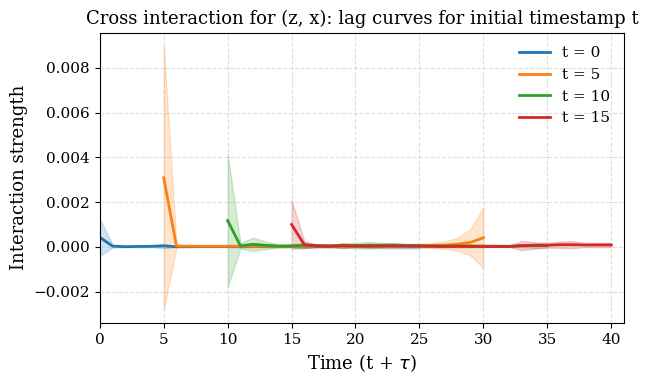

In [44]:
CROSS_PAIRS  = [[0, 1], [1, 2], [2, 0]]          # cross feature pairs

for d_idx1, d_idx2 in CROSS_PAIRS:
    fig, ax = plt.subplots(figsize=(6.5, 4))

    for t0, c in zip(T_CHOICES, colors):
        if t0 >= T_init:
            continue

        # slice: [B, tau] for this feature at anchor time t0
        vals = ih[:, t0, :, d_idx1, d_idx2]      # [B, tau]
        strength = np.abs(vals)

        mean = strength.mean(axis=0)           # [tau]
        std  = strength.std(axis=0)            # [tau]

        # shift curve horizontally by t0
        x = taus + t0

        ax.plot(x, mean, color=c, label=f"t = {t0}")
        ax.fill_between(x, mean - std, mean + std, color=c, alpha=0.20)

    ax.set_xlabel(r"Time (t + $\tau$)")
    ax.set_ylabel("Interaction strength")
    ax.set_title(f"Cross interaction for ({feature_idx_to_name_map[d_idx1]}, {feature_idx_to_name_map[d_idx2]}): lag curves for initial timestamp t")
    ax.legend(frameon=False)
    ax.set_xlim(0, max(T_CHOICES) + tau_dim)
    fig.tight_layout()

plt.show()

## autocorrelation

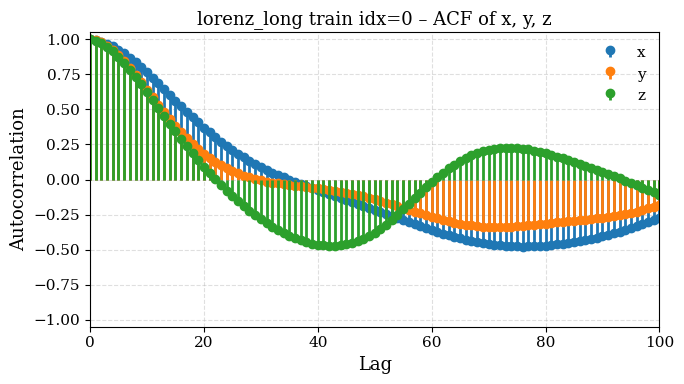

In [46]:
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ---------- load one trajectory ----------
ds_name = "lorenz_long"
split = "train"          # or "val"
idx = 0                  # which trajectory to inspect

pkl_path = Path("../data") / ds_name / f"{split}.pkl"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

X = np.asarray(data["X"])   # [N, T, 6]
y = np.asarray(data["y"])   # [N, T]

X_sample = X[idx]           # [T, 6]
xyz = X_sample[:, :3]       # [T, 3]
T = xyz.shape[0]

# ---------- ACF helper ----------
def acf_1d(x, max_lag=None):
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    var = np.dot(x, x)

    if max_lag is None:
        max_lag = len(x) - 1

    acf_vals = []
    for k in range(max_lag + 1):
        if k == 0:
            acf_vals.append(1.0)
        else:
            num = np.dot(x[k:], x[:-k])
            acf_vals.append(num / var)
    return np.array(acf_vals)

max_lag = min(100, T - 1)

acf_x = acf_1d(xyz[:, 0], max_lag)
acf_y = acf_1d(xyz[:, 1], max_lag)
acf_z = acf_1d(xyz[:, 2], max_lag)
lags = np.arange(max_lag + 1)

# ---------- plotting ----------
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.4,
    "grid.linestyle": "--",
    "lines.linewidth": 2.0,
})

fig, ax = plt.subplots(figsize=(7, 4))

# Older matplotlib: no use_line_collection
ax.stem(lags, acf_x, linefmt="C0-", basefmt=" ")
ax.stem(lags, acf_y, linefmt="C1-",  basefmt=" ")
ax.stem(lags, acf_z, linefmt="C2-", basefmt=" ")

ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title(f"{ds_name} {split} idx={idx} – ACF of x, y, z")
ax.legend(["x", "y", "z"], frameon=False)
ax.set_xlim(0, max_lag)
ax.set_ylim(-1.05, 1.05)

fig.tight_layout()
plt.show()
